# Connected Polynomial Guidance

Pure python implementation of the connected polynomial guidance approach developed by Guru Singh. Reproduces both examples from the reference. 

Reference: IOM 3433-20-001

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 

## Definition of Inputs and Vehicle Parameters

In [238]:
target_alt = 500

# Vehicle Parameters 
Tmax = 31198.7 # N 
tau_max = 0.8
tau_min = 0.2 
inefficiency = 0.98481
Isp = 220
g0 = 9.807

# Initial Conditions 
m0 = 2650
x0 = 0
y0 = 0 
z0 = 2500

V = 100
fpa = np.radians(-65)
vx = V*np.cos(fpa)
vy = 0
vz = V*np.sin(fpa)

# These are problem/vehicle specific, fixed values 
z1 = 1050
dz1 = 0 

p0 = [x0, y0, z0]
v0 = [vx, vy, vz]
x0 = np.array(p0+v0)



In [236]:
def coeff(x0, dx0, x1, dx1, xf, Ta, Tb):
    cxa5 = -7/6 * (3*x0-3*x1+dx0*Ta+2*dx1*Ta)
    cxa = np.array([x0, dx0*Ta, -cxa5-6*x0+6*x1-3*dx0*Ta-3*dx1*Ta, 3*cxa5+8*x0-8*x1+3*dx0*Ta+5*dx1*Ta, -3*cxa5-3*x0+3*x1-dx0*Ta-2*dx1*Ta, cxa5])[::-1]
    
    cxb6 = 1.5*dx1*Tb
    cxb = np.array([x1, dx1*Tb, 0, -1*cxb6 - 10*x1 - 6*Tb*dx1 + 10*xf, 3*cxb6 + 15*x1 + 8*Tb*dx1 - 15*xf, -3*(cxb6 + 2*x1 + Tb*dx1 - 2*xf), cxb6])[::-1]
    return cxa, cxb

def solve(initial_state, target_state, final_vertical_accel, interior_point, debug=False):
    p0 = initial_state[:3]
    v0 = initial_state[3:]
    
    pf = target_state[:3]
    vf = target_state[3:]
    
    z1, dz1 = interior_point 
    
    x0,y0,z0, dx0,dy0,dz0 = initial_state # for easy access to individual states 
    xf,yf,zf, dxf,dyf,dzf = target_state
    
    # Compute r boundary conditions
    r = pf-p0
    r[2] = 0 
    rhat = r/np.linalg.norm(r)
    alpha,beta,unused = rhat
    dr0 = np.dot(rhat, v0)
    rf = np.dot(rhat, pf-p0)
    
    # Segment times 
    Ta = -2*(z0-z1)/(dz0+dz1)
    Tb = -2*(z1-zf)/(dz1+dzf)
    if debug:
        print("Ta = {:.2f}".format(Ta))
        print("Tb = {:.2f}".format(Tb))    
    
    # Interior Point r coordinates 
    num = 56*(-16*Ta**2 - 15*Ta*Tb+4*Tb**2)*dr0 + 120*(16*Ta+15*Tb)*rf
    den = 1024*Ta**2 + 1920*Ta*Tb + 1349*Tb**2
    dr1 = num/den
    r1 = Ta*(7*dr0 + 8*dr1)/15
    if debug:
        print("r1 = {:.2f}".format(r1))
        print("dr1 = {:.2f}".format(dr1))
    
    x1 = x0 + alpha*r1
    y1 = y0 + beta*r1
    
    dx1 = alpha*dr1
    dy1 = beta*dr1 
    
    # Get the coefficients...very tedious 
    cxa,cxb = coeff(x0, dx0, x1, dx1, xf, Ta, Tb)
    cya,cyb = coeff(y0, dy0, y1, dy1, yf, Ta, Tb)
    cza = np.array([z0, dz0*Ta, -dz0*Ta - z0 + z1])[::-1]
    czb = np.array([z1, dz1*Tb, -dz1*Tb - z1 + zf])[::-1] # reversing them makes them usable with polyval 
    
    # Times at which to evaluate the trajectory 
    ta = np.linspace(0, Ta)
    tb = np.linspace(0, Tb)
    
       
    def get_reference_state(time):
        # lets just assume time is a vector rather than a scalar 
        
        a = time <= Ta
        b = np.invert(a)
        ta = time[a]
        tb = time[b]-ta[-1]
        
        xa = np.polyval(cxa, ta/Ta)
        xb = np.polyval(cxb, tb/Tb)
        x = np.hstack([xa,xb])
        
        ya = np.polyval(cya, ta/Ta)
        yb = np.polyval(cyb, tb/Tb)
        y = np.hstack([ya,yb])

        za = np.polyval(cza, ta/Ta)
        zb = np.polyval(czb, tb/Tb)
        z = np.hstack([za,zb])
        
        dxa = np.polyval(np.polyder(cxa), ta/Ta)/Ta
        dxb = np.polyval(np.polyder(cxb), tb/Tb)/Tb
        dx = np.hstack([dxa,dxb])
        
        dya = np.polyval(np.polyder(cya), ta/Ta)/Ta
        dyb = np.polyval(np.polyder(cyb), tb/Tb)/Tb
        dy = np.hstack([dya,dyb])        
        
        dza = np.polyval(np.polyder(cza), ta/Ta)/Ta
        dzb = np.polyval(np.polyder(czb), tb/Tb)/Tb
        dz = np.hstack([dza,dzb])
        
        return np.array([x, y, z, dx, dy, dz]).T
    
    def get_reference_accel(time):
        a = time <= Ta
        b = np.invert(a)
        ta = time[a]
        tb = time[b]-Ta
        
        accel = []
        for ca,cb in [(cxa,cxb), (cya,cyb), (cza,czb)]:
            ddxa = np.polyval(np.polyder(ca, 2), ta/Ta)/Ta**2
            ddxb = np.polyval(np.polyder(cb, 2), tb/Tb)/Tb**2
            accel.append(np.hstack([ddxa,ddxb]))       
        accel[2] += 3.71 # we want to return only the thrust accelerations, so we remove the gravitational effects 
        return np.array(accel).T
    

    
    t = np.linspace(0, Ta+Tb, 500)
    x,y,z,dx,dy,dz = get_reference_state(t).T

    acc = get_reference_accel(t)
    accel_norm = np.sqrt(np.sum(acc**2, axis=1))

    m = [m0]
    for accel in accel_norm[:-1]:
        m.append(m[-1] - accel*m[-1]*t[1]/Isp/g0/inefficiency)
    m = np.array(m)
    mprop = m0-m
    if debug:
        print("Prop used: {:.3f} kg".format(mprop[-1]))
    T = m*accel_norm/inefficiency

    def plot_results():
        plt.figure()
        plt.title("Positions")
        plt.plot(x, z, label="Along track")
        plt.plot(y, z, label="Cross track")
        plt.ylabel('Altitude (m)')
        plt.xlabel("Horizontal distance (m)")
        plt.legend()
        
        plt.figure()
        plt.plot(t, dx, label='vx')
        plt.plot(t, dy, label='vy')
        plt.plot(t, dz, label='vz')
        plt.plot(t, np.sqrt(dx**2 + dy**2 + dz**2), 'k--', label='||V||')
        plt.xlabel('Time (s)')
        
        plt.legend()
        
        plt.figure()
        plt.plot(t, mprop)
        plt.ylabel("Prop Used (kg)")   
        plt.xlabel('Time (s)')
        
        plt.figure()
        plt.plot(t, T/Tmax)
        plt.ylabel("Throttle %")
        plt.xlabel('Time (s)')
        
        plt.show()
    
        # This should have absolutely everything we need 
    solution = {'coeff': {'a':[cxa, cya, cza], 'b': [cxb, cyb, czb], 'x': [cxa,cxb], 'y': [cya,cyb],'z': [cza,czb],},
                'times': {'Ta': Ta, 'Tb': Tb,"Tf": Ta+Tb},
                'time_history': {'state': get_reference_state, 'control': interp1d(t, T), 'mass': interp1d(t, m)},
                'prop': mprop[-1],
                'throttle_bounds': (np.min(T/Tmax), np.max(T/Tmax)),
                'plot': plot_results,
               } 

    if debug:
        plot_results()
        plt.show()
    return solution 

Ta = 32.00
Tb = 36.67
r1 = 1295.57
dr1 = 112.90
Prop used: 482.869 kg


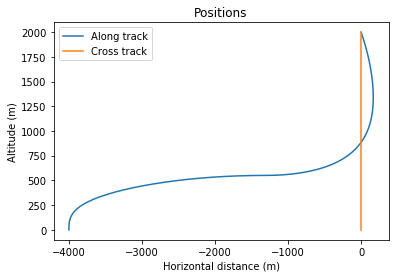

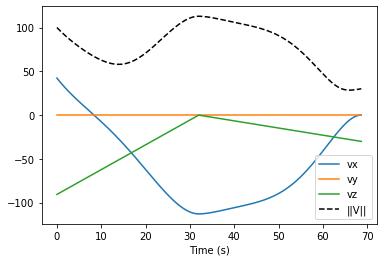

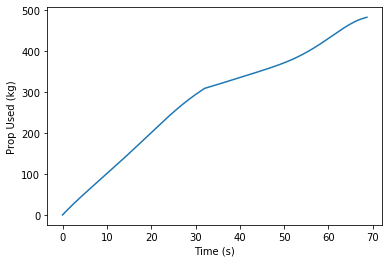

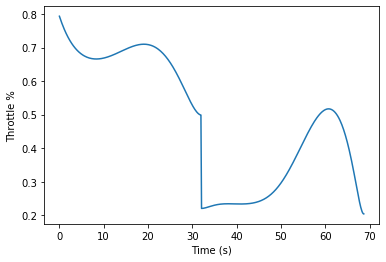



Ta = 32.00
Tb = 36.67
r1 = 1700.78
dr1 = 99.66
Prop used: 455.604 kg


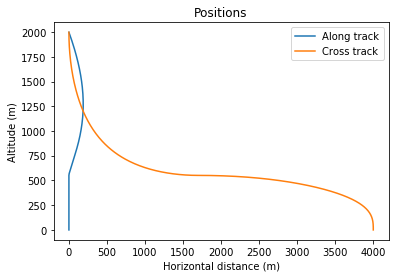

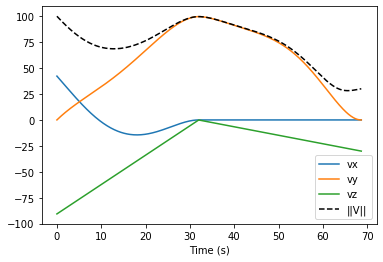

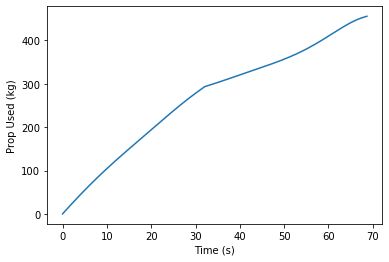

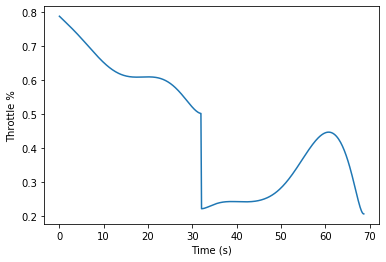

In [239]:
# Target conditions 
pf1 = [-4000, 0, target_alt] # case 1 in the memo
pf2 = [0, 4000, target_alt]  # case 2
vf = [0, 0, -30]

for pf in [pf1, pf2]:
    xf = np.array(pf+vf)
    sol = solve(x0, xf, 0, [z1, dz1], debug=True)
    print("\n")

## Questions
- Is there any enforcement of constraints? Are throttle limits respected merely by choosing the right ignition state?
- What is the procedure given a new mission/vehicle? How do we choose those fixed parameters? 

## Monte Carlo on Target Position

Propellant Usage Statistics:
 429.9 +/- 108.4 kg (3-sigma)
Bounds: [369.3, 535.1] kg


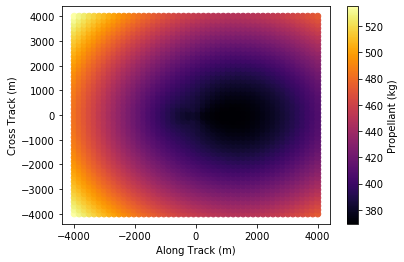

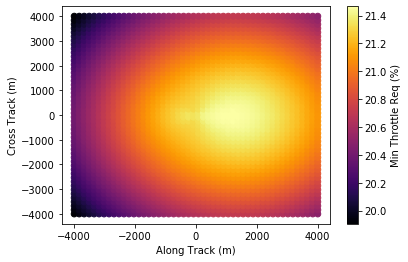

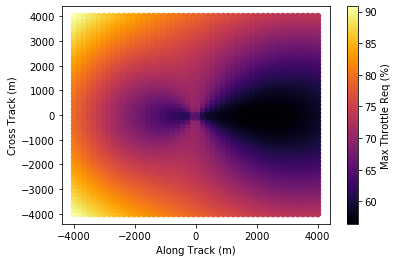

In [169]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

# Target conditions 
vf = [0, 0, -30]
x = np.linspace(-4000, 4000, 50)
xfx = cartesian_product(x,x)

prop = []
throttle = []
for pf in xfx:
    pf = np.append(pf, target_alt)
    xf = np.hstack((pf,vf))
    sol = solve(x0, xf, 0, [z1, dz1], debug=False)
    prop.append(sol['prop'])
    throttle.append(sol['throttle_bounds'])

    
prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_lims = np.min(prop), np.max(prop)
print("Propellant Usage Statistics:\n {:.1f} +/- {:.1f} kg (3-sigma)\nBounds: [{:.1f}, {:.1f}] kg".format(prop_mean, 3*prop_std, *prop_lims))

throttle = np.array(throttle)
cmap = 'inferno'

plt.figure()
plt.scatter(xfx.T[0], xfx.T[1], c=prop, cmap=cmap)
plt.xlabel("Along Track (m)")
plt.ylabel("Cross Track (m)")
plt.colorbar(label="Propellant (kg)")
plt.show()

plt.figure()
plt.scatter(xfx.T[0], xfx.T[1], c=throttle.T[0]*100, cmap=cmap)
plt.xlabel("Along Track (m)")
plt.ylabel("Cross Track (m)")
plt.colorbar(label="Min Throttle Req (%)")
plt.show()

plt.figure()
plt.scatter(xfx.T[0], xfx.T[1], c=throttle.T[1]*100, cmap=cmap)
plt.xlabel("Along Track (m)")
plt.ylabel("Cross Track (m)")
plt.colorbar(label="Max Throttle Req (%)")
plt.show()

The closed form nature of the approach makes it extremely amenable to Monte Carlo analysis. The fixed parameters $(z_1,\, \dot{z}_1)$ can be chosen by sweeping over a range of values with a MC performed at each to determine near-optimal values.

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450


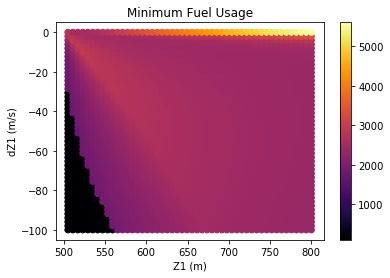

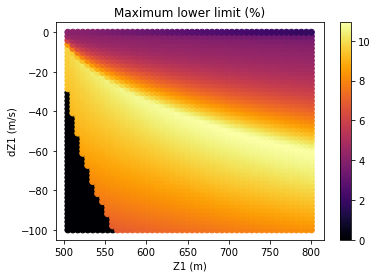

In [228]:
# TODO: Try using heavy EDL vehicle and determine suitable z1, dz1 parameters 

target_alt = 500

# Vehicle Parameters 
Tmax = 70*8500 # N 
tau_max = 1
tau_min = (40*8500)/Tmax 
inefficiency = 1
Isp = 260
g0 = 9.807

# Initial Conditions 
m0 = 8500
x0 = 0
y0 = 0 
z0 = 2500

V = 525
fpa = np.radians(-15)
vx = V*np.cos(fpa)
vy = 0
vz = V*np.sin(fpa)
x0 = [x0,y0,z0,vx,vy,vz]


# Target conditions 
vf = [0, 0, -1]
x = np.linspace(2000, 12000, 500)
# y = np.linspace(0, 3000, 15)
y = np.array([0])
Xfx = np.array(cartesian_product(x, y))
# Xfx = np.array([[2000, 0]])
stats = []
# These are problem/vehicle specific, fixed values 
Z1 = np.linspace(505, 800, 50)
# Z1 = [600]
dZ1 = np.linspace(-100, 0, 50)
params = cartesian_product(Z1, dZ1)
for z1,dz1 in params:
    prop = []
    throttle = []
    if not len(stats) % 50:
        print(len(stats))
    for pf in Xfx:
        pf = np.append(pf, target_alt)
        xf = np.hstack((pf,vf))
        sol = solve(x0, xf, 0, [z1, dz1], debug=False)
        if sol['times']['Tb'] <= 0: # Poorly configured cases, throw them out 
            sol['prop'] = np.nan
        prop.append(sol['prop'])
        throttle.append(sol['throttle_bounds'])

    keep = np.invert(np.isnan(prop))  # toss out NaN cases 
    throttle = np.array(throttle)
    keep = np.logical_and(throttle.T[1] <= tau_max, keep) # toss out cases required more thrust than available 
#     keep = = np.logical_and(throttle[0] >= tau_min, keep) # toss out cases requiring lower throttle than we can set

    prop = np.array(prop)[keep]
    throttle = throttle[keep]
    xfx = Xfx[keep]
    
    prop_mean = np.mean(prop)
    prop_std = np.median(prop)
    try:
        prop_lims = np.min(prop), np.max(prop)
        throttle_lims = np.max(throttle.T[0]), np.min(throttle.T[1]) # we want the highest of the lower lim, and the lowest of the higher limit?
    except ValueError:
        prop_mean = np.nan
        prop_std = np.nan
        prop_lims = (0,100)
        throttle_lims = (0,100)
    stats.append([prop_mean, prop_std, *prop_lims,*throttle_lims])
#     print("Propellant Usage Statistics ({}, {}):\n {:.1f}, {:.1f} kg (mean, median)\nBounds: [{:.1f}, {:.1f}] kg".format(z1, dz1,prop_mean, prop_std, *prop_lims))
    
    cmap = 'inferno'
    if 0:
        plt.figure()
        plt.scatter(xfx.T[0], xfx.T[1], c=prop, cmap=cmap)
        plt.xlabel("Along Track (m)")
        plt.ylabel("Cross Track (m)")
        plt.colorbar(label="Propellant (kg)")
        plt.show()

        plt.figure()
        plt.scatter(xfx.T[0], xfx.T[1], c=throttle.T[0]*100, cmap=cmap)
        plt.xlabel("Along Track (m)")
        plt.ylabel("Cross Track (m)")
        plt.colorbar(label="Min Throttle Req (%)")
        plt.show()

        plt.figure()
        plt.scatter(xfx.T[0], xfx.T[1], c=throttle.T[1]*100, cmap=cmap)
        plt.xlabel("Along Track (m)")
        plt.ylabel("Cross Track (m)")
        plt.colorbar(label="Max Throttle Req (%)")
        plt.show()
        
stats = np.array(stats)

plt.figure()
plt.scatter(*params.T, c=stats[:,3], cmap=cmap)
plt.xlabel("Z1 (m)")
plt.ylabel("dZ1 (m/s)")
plt.title("Minimum Fuel Usage")
plt.colorbar()

plt.figure()
plt.scatter(*params.T, c=stats[:,4]*100, cmap=cmap)
plt.xlabel("Z1 (m)")
plt.ylabel("dZ1 (m/s)")
plt.title("Maximum lower limit (%)")
plt.colorbar()

# plt.figure()
# plt.plot(Z1, stats[:,0], 'k*-', label="Mean")
# plt.plot(Z1, stats[:,1], 'k*-', label="Median")

# plt.plot(Z1, stats[:,2], 'r', label="Extrema")
# plt.plot(Z1, stats[:,3], 'r')

# plt.fill_between(Z1, *stats[:,2:].T, alpha=0.2, color='k')
# plt.legend()
# plt.show()

In [234]:
fuel = stats[:,3]
opt = np.argmin(fuel[fuel>1000])
print(params[fuel>1000][opt])
print(fuel[fuel>1000][opt])

[505.         -28.57142857]
1718.901080541701
